This file is meant to test fb prophet and functions, actual working file is Testing Prophet with Multiplicity. 

In [502]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics




#data_path_write = 'C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Time_predictions_on_all_columns\\'
#fa = pd.read_csv(data_path)
#entire_dataset = pd.read_csv(data_path2)

Function to pick which data to perform time prediction analysis on. 1 is for emails received, 2 is all gmail data, 3 is the five attributes

In [503]:
def pick_your_poison(number):
    if (number == 1):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\cbt.csv")
        print("You picked cbt.csv")
    if (number == 2):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\gmail_df.csv")
        print("You picked overall data")
    if (number == 3):
        df = pd.read_csv("C:\\Users\\augus\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\gmail_df.csv")
        df = df[['time','emails_received','emails_sent','inbound_rejected_emails','inbound_spam_emails','inbound_non_spam_emails']]
        print("The five attributes")
    else:
        df = []
        print("No dataset for you")
    return df
    

Function to pass column time as a date time object and set time as an index. It is important for plotting

In [504]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df

Function to plot the predicted values and the original data

In [505]:
def plot(df,df0):
    df1 = df.copy()
    df2 = df0.copy()
    df1 = time_set(df1)
    df2 = time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

Function to do time prediction with log

In [506]:
#p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative', growth = "linear")

#def semester(ds):
   # date = pd.to_datetime(ds)
   # return ((date.month >= 8 or date.month < 12) and (date.month >= 1 or date.month < 5))
def timepredictionLog(df,csvfilename):
    p = Prophet(weekly_seasonality=True, changepoint_prior_scale=0.8)
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    df['y'] = df['y'] + 1
    df['y'] = np.log(df['y'])
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df['y'] = np.exp(df['y'])-1
    #time_pred[time_pred.columns[1:]] = np.exp(time_pred[time_pred.columns[1:]])
    time_pred['yhat'] = np.exp(time_pred['yhat'])-1
    df1 = time_pred[['ds','yhat']]
    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    print(csvfilename)
    p.plot(time_pred)
    return df1,df2,time_pred

Function to do time prediction without log

In [507]:
def timeprediction123(df,csvfilename):
    p = Prophet(weekly_seasonality=True,changepoint_prior_scale=0.3)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    print(csvfilename)
    p.plot(time_pred)
    return df1,df2,time_pred

Function to send all columns in a dataframe to timeprediction123

In [508]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1] + '_time_prediction.csv')[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1] + '_time_prediction.csv')[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

Time prediction actually begins here

In [509]:
five_att = pick_your_poison(3)

The five attributes


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_received_time_prediction.csv
  horizon           mse          rmse           mae  coverage
0 37 days  8.635715e+09  92928.550422  59131.926808  0.742978
1 38 days  8.516837e+09  92286.710100  58670.743547  0.749438
2 39 days  8.551807e+09  92475.979280  59247.180597  0.752809
3 40 days  8.670872e+09  93117.518551  60060.152055  0.749438
4 41 days  9.473970e+09  97334.321826  61458.326785  0.749438
Performance tail for emails_received_time_prediction.csv
     horizon           mse          rmse           mae  coverage
324 361 days  7.043124e+09  83923.320523  63613.294088  0.667416
325 362 days  7.079480e+09  84139.644968  63804.616745  0.666292
326 363 days  7.133675e+09  84461.085352  64022.139085  0.660674
327 364 days  7.173565e+09  84696.898135  64256.091736  0.660674
328 365 days  7.194371e+09  84819.635491  64236.524913  0.660674
emails_received_time_prediction.csv


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_sent_time_prediction.csv
  horizon           mse          rmse          mae  coverage
0 37 days  1.050600e+08  10249.878505  6609.794810  0.821629
1 38 days  1.049733e+08  10245.648240  6631.164716  0.820225
2 39 days  1.055953e+08  10275.956623  6703.564639  0.820225
3 40 days  1.086713e+08  10424.553514  6810.116192  0.814607
4 41 days  1.173856e+08  10834.463031  6991.890471  0.808989
Performance tail for emails_sent_time_prediction.csv
     horizon           mse         rmse          mae  coverage
324 361 days  6.116667e+07  7820.912084  5207.515474  0.857303
325 362 days  6.092078e+07  7805.176473  5166.987650  0.859551
326 363 days  6.106780e+07  7814.589206  5182.365892  0.859551
327 364 days  5.899547e+07  7680.850586  5129.410111  0.862921
328 365 days  5.734373e+07  7572.564454  5054.225448  0.865169
emails_sent_time_prediction.csv


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_rejected_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 37 days  4.116820e+08  20289.947992  16890.965731  1.816017  0.546348
1 38 days  4.274146e+08  20674.008156  17292.321235  1.840883  0.526966
2 39 days  4.441669e+08  21075.267942  17677.762656  1.883967  0.511236
3 40 days  5.092127e+08  22565.741574  18591.449318  1.921377  0.485393
4 41 days  5.320365e+08  23065.916600  19062.449108  1.961349  0.462921
Performance tail for inbound_rejected_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
324 361 days  2.594374e+09  50934.996292  50184.596393  9.007452  0.607865
325 362 days  2.608557e+09  51074.037557  50282.035220  9.047219  0.607865
326 363 days  2.610777e+09  51095.762419  50275.672596  9.062693  0.607865
327 364 days  2.613156e+09  51119.033318  50274.900640  9.090956  0.607865
328 365 days  2.612309e+09  51110.748557  50264.738889  9.14002

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_spam_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.755489e+08  13249.488286  10903.691421  0.278509  0.613764
1 38 days  1.801723e+08  13422.827448  11084.647948  0.284825  0.601124
2 39 days  1.904339e+08  13799.777392  11366.710323  0.293426  0.589888
3 40 days  2.014484e+08  14193.252261  11693.343461  0.302046  0.575281
4 41 days  2.092172e+08  14464.341360  11943.437786  0.309212  0.566292
Performance tail for inbound_spam_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
324 361 days  1.152797e+09  33952.863934  29806.730333  1.064992  0.994382
325 362 days  1.162710e+09  34098.531775  29902.182926  1.057166  0.994382
326 363 days  1.162090e+09  34089.447901  29918.003232  1.061039  0.994382
327 364 days  1.163716e+09  34113.283246  30007.933689  1.070818  0.994382
328 365 days  1.167042e+09  34161.993667  30120.974515  1.080896  0.997

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_non_spam_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.197216e+09  34600.803601  26704.773974  0.156131  0.664326
1 38 days  1.248190e+09  35329.737047  27476.401070  0.159248  0.653933
2 39 days  1.281415e+09  35796.854282  27851.502589  0.160742  0.642697
3 40 days  1.383009e+09  37188.825228  28862.386556  0.168070  0.622472
4 41 days  1.416770e+09  37640.009176  29439.459847  0.173370  0.616854
Performance tail for inbound_non_spam_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
324 361 days  3.128843e+09  55936.057738  47815.326703  0.331463  0.810112
325 362 days  3.152292e+09  56145.278396  47803.824071  0.328938  0.808989
326 363 days  3.263129e+09  57123.806048  48647.841375  0.329998  0.801124
327 364 days  3.334809e+09  57747.800931  49362.396678  0.330421  0.801124
328 365 days  3.357017e+09  57939.770753  49595.745629  0.32841

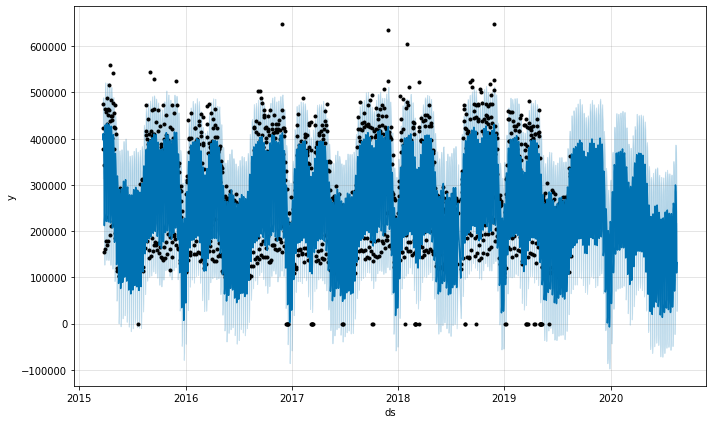

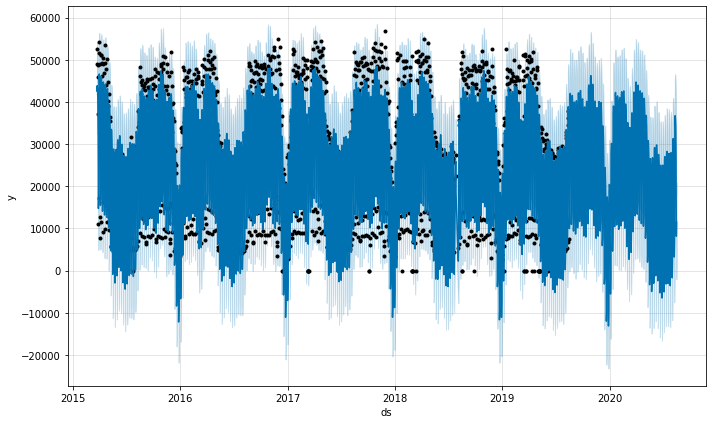

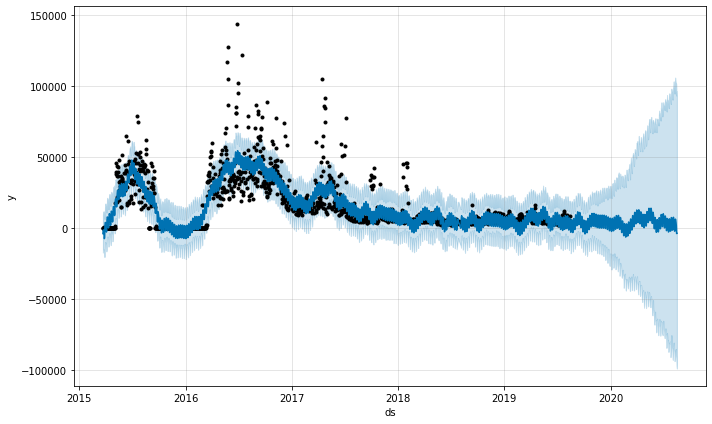

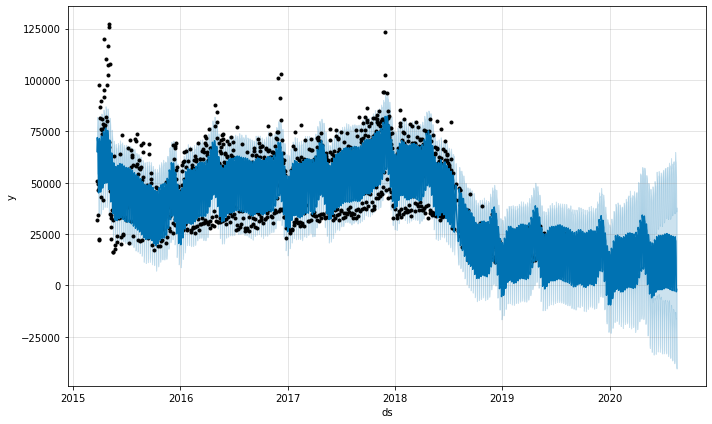

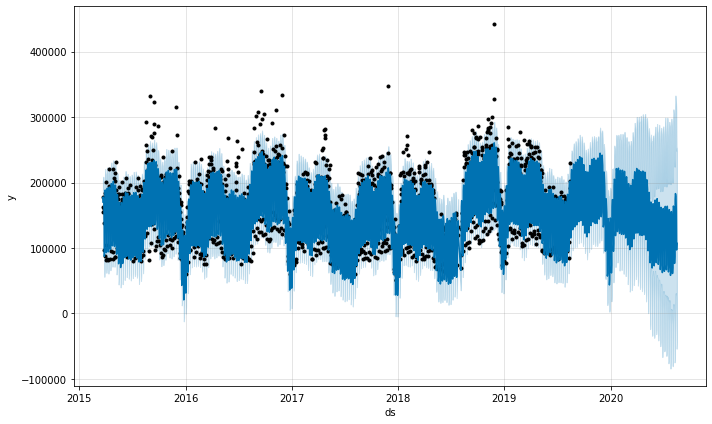

In [510]:
prediction = send_prediction(five_att)

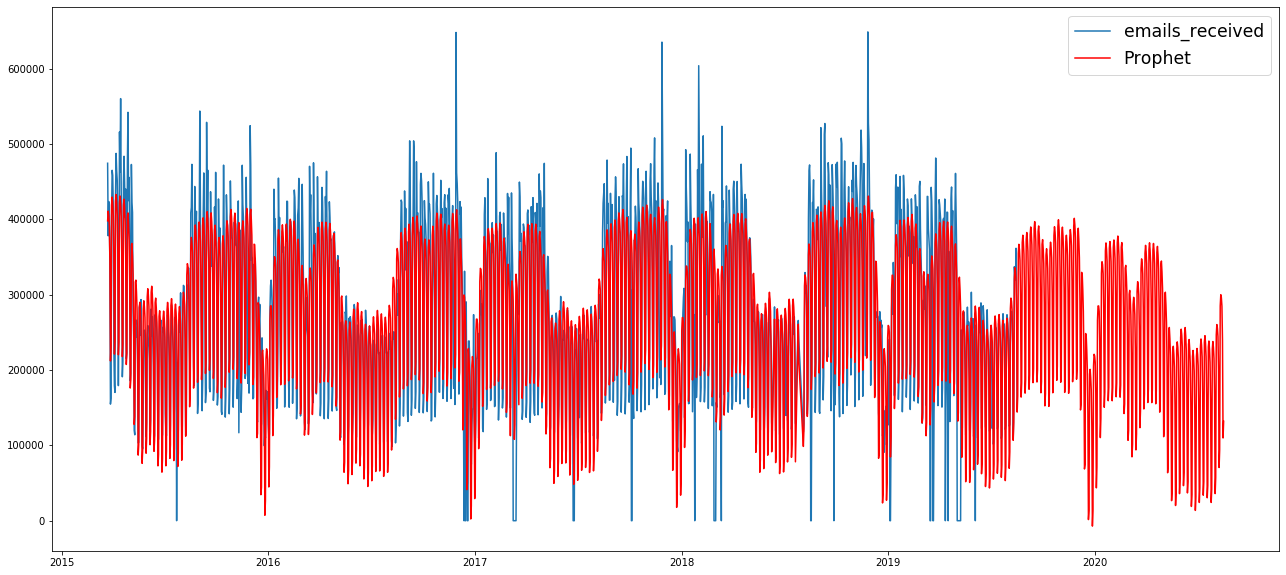

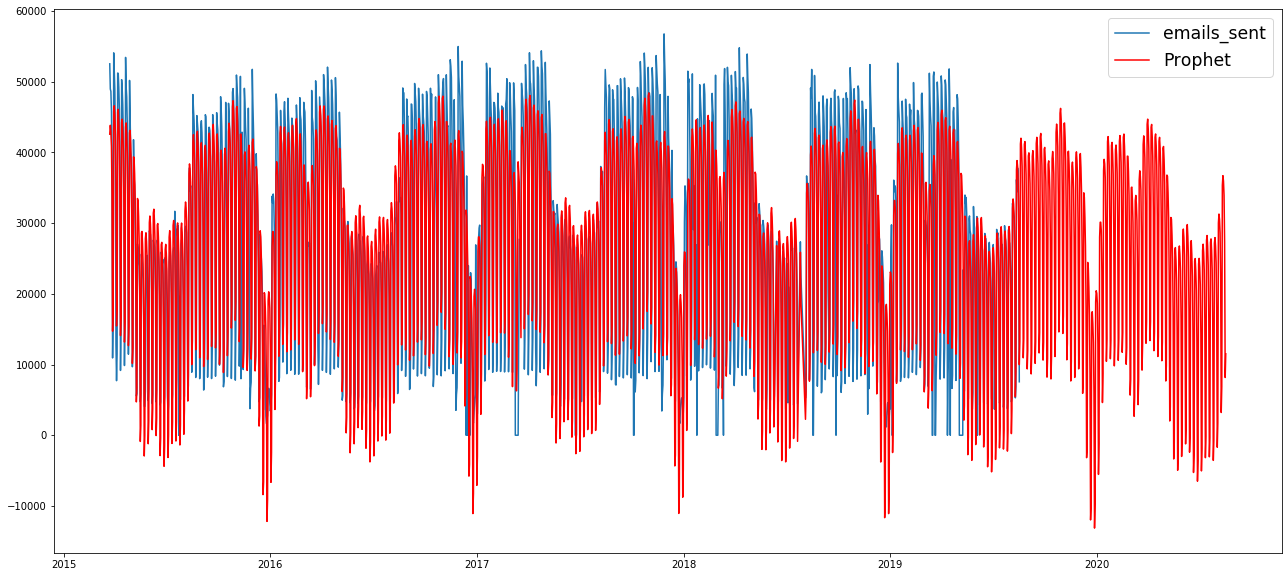

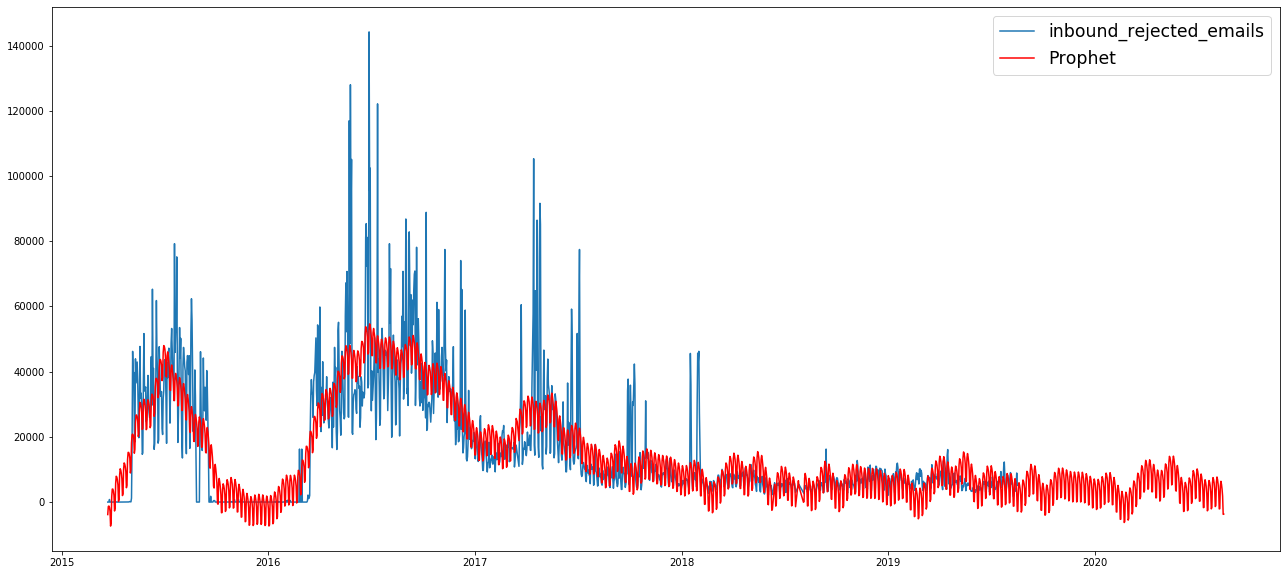

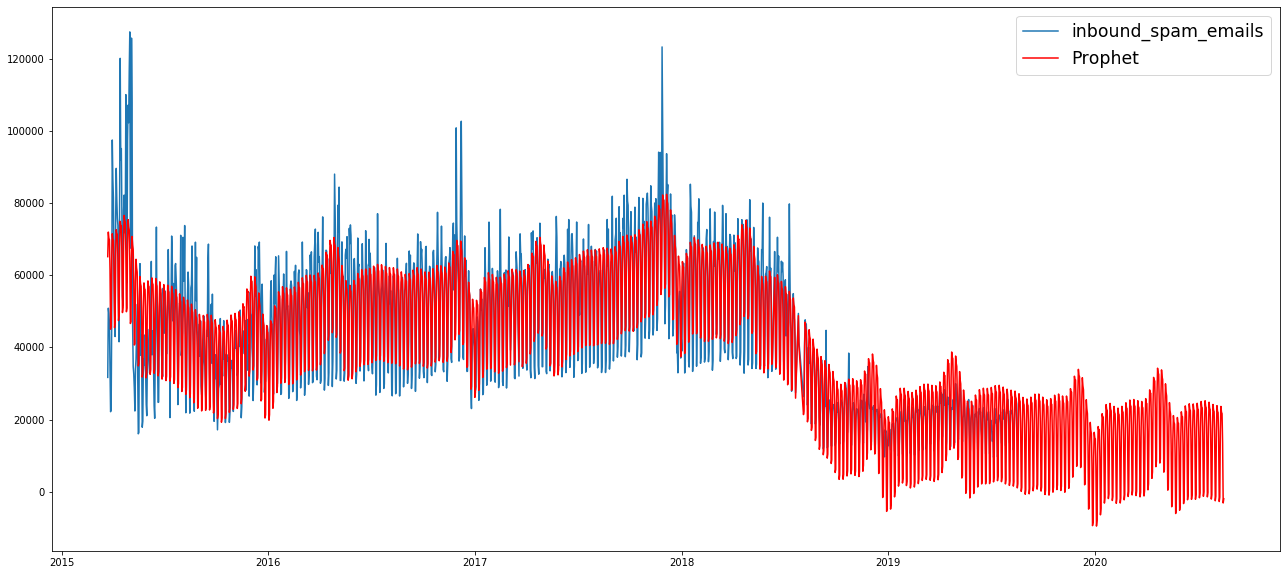

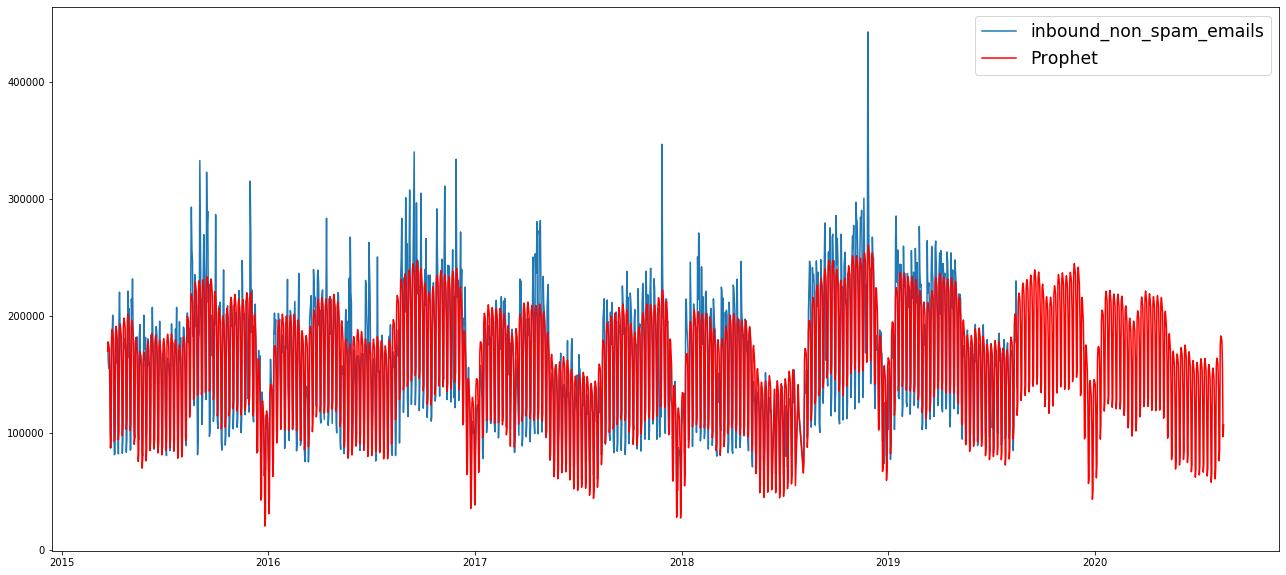

In [511]:
plot(five_att,prediction)

In [512]:
prediction

,time,emails_received,emails_sent,inbound_rejected_emails,inbound_spam_emails,inbound_non_spam_emails
0,2015-03-23,398046.181675,42582.754699,-3829.465009,65150.876386,170119.747282
1,2015-03-24,410926.091280,43843.451908,-1358.827031,71958.460595,177946.662696
2,2015-03-25,404965.568898,42956.581531,-1204.010933,70286.901454,175538.164499
3,2015-03-26,391537.086312,40811.302276,-1615.220269,69812.795423,171422.384646
4,2015-03-27,344615.139408,34040.945706,-2769.617787,61648.593409,147898.363272
5,2015-03-28,212055.659773,14720.293484,-7362.469911,45069.425082,87336.503261
6,2015-03-29,231971.862306,17922.376516,-6317.063033,46297.559224,96306.954176
7,2015-03-30,419069.286416,45830.211866,1639.514917,64500.372702,181989.031381
8,2015-03-31,429591.427683,46602.483827,3979.828132,71493.977536,188559.890815
9,2015-04-01,421189.141965,45206.637534,3985.608182,70024.168930,184858.961103


Removing 0s when there is an outage

In [513]:
five_att_0_removed = pick_your_poison(3)

The five attributes


In [514]:
five_att_0_removed = five_att_0_removed [five_att_0_removed ['emails_received'] != 0] 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_received_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 38 days  3.544317e+09  59534.165923  44117.120470  0.160070  0.754386
1 39 days  3.562152e+09  59683.770387  44427.535827  0.161752  0.747368
2 40 days  3.704815e+09  60867.193581  45658.417201  0.167602  0.736842
3 41 days  3.692700e+09  60767.593954  45470.658348  0.168063  0.740351
4 42 days  3.684474e+09  60699.869034  45302.008265  0.167991  0.740351
Performance tail for emails_received_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  5.459336e+09  73887.319112  58558.458701  0.233794  0.622222
324 362 days  5.596958e+09  74812.821086  59316.513524  0.233543  0.610526
325 363 days  5.653323e+09  75188.582871  59536.052934  0.233000  0.604678
326 364 days  5.624539e+09  74996.927762  59554.158546  0.233326  0.607018
327 365 days  5.607598e+09  74883.895932  59290.982191  0.233346  0.615205
emai

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_sent_time_prediction.csv
  horizon           mse         rmse          mae      mape  coverage
0 38 days  4.525056e+07  6726.853856  5004.943298  0.256979  0.836257
1 39 days  4.582046e+07  6769.080917  5073.501559  0.260490  0.830409
2 40 days  4.912758e+07  7009.106701  5199.911242  0.272473  0.824561
3 41 days  4.911106e+07  7007.928572  5191.518786  0.275573  0.824561
4 42 days  4.895686e+07  6996.917725  5140.681484  0.275696  0.818713
Performance tail for emails_sent_time_prediction.csv
     horizon           mse         rmse          mae      mape  coverage
323 361 days  5.259130e+07  7251.985977  5293.116174  0.312777  0.795322
324 362 days  5.279592e+07  7266.079798  5296.199891  0.307080  0.791813
325 363 days  5.135355e+07  7166.138823  5255.925413  0.302402  0.791813
326 364 days  4.849925e+07  6964.140058  5124.841100  0.295768  0.795322
327 365 days  4.732201e+07  6879.099499  5037.634888  0.293303  0.800000
emails_sent_time_prediction.csv


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_rejected_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 38 days  4.630284e+08  21518.093802  18155.932450  1.915520  0.508772
1 39 days  4.805773e+08  21922.073966  18565.256356  1.961810  0.488889
2 40 days  5.549514e+08  23557.405916  19583.987370  1.998554  0.461988
3 41 days  5.769019e+08  24018.781786  20010.270296  2.030374  0.442105
4 42 days  5.989396e+08  24473.242993  20528.187713  2.083047  0.418713
Performance tail for inbound_rejected_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  2.432230e+09  49317.641860  48251.405403  8.653486  0.618713
324 362 days  2.444763e+09  49444.543788  48316.178923  8.724341  0.618713
325 363 days  2.447939e+09  49476.654018  48312.485675  8.772152  0.618713
326 364 days  2.444678e+09  49443.680143  48248.430063  8.789276  0.626901
327 365 days  2.444505e+09  49441.934293  48216.227664  8.83399

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_spam_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 38 days  1.675126e+08  12942.664634  10639.720101  0.276782  0.612086
1 39 days  1.770228e+08  13304.992720  10896.085865  0.285246  0.602339
2 40 days  1.878057e+08  13704.221103  11223.476012  0.294065  0.590643
3 41 days  1.920713e+08  13858.977742  11382.732703  0.296232  0.582456
4 42 days  1.970499e+08  14037.447520  11589.599676  0.305027  0.574269
Performance tail for inbound_spam_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  1.054041e+09  32465.999286  28754.845692  1.057540       1.0
324 362 days  1.060108e+09  32559.301711  28833.342645  1.051706       1.0
325 363 days  1.060482e+09  32565.043184  28871.654871  1.057230       1.0
326 364 days  1.058783e+09  32538.949550  28893.085087  1.066222       1.0
327 365 days  1.065131e+09  32636.340761  29018.806551  1.076323       

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_non_spam_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 38 days  1.282173e+09  35807.444491  28018.450875  0.162881  0.664717
1 39 days  1.322731e+09  36369.372465  28543.416288  0.165090  0.653801
2 40 days  1.438705e+09  37930.265951  29626.753407  0.172395  0.630409
3 41 days  1.460144e+09  38211.826175  29998.202013  0.177260  0.626901
4 42 days  1.501467e+09  38748.768807  30619.726620  0.184063  0.621053
Performance tail for inbound_non_spam_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  2.987573e+09  54658.692845  46090.475188  0.319316  0.789474
324 362 days  3.015457e+09  54913.176367  46113.914058  0.317205  0.788304
325 363 days  3.125764e+09  55908.531068  47068.497468  0.318752  0.785965
326 364 days  3.180605e+09  56396.849074  47739.020044  0.319140  0.788304
327 365 days  3.196267e+09  56535.534098  47822.797985  0.31674

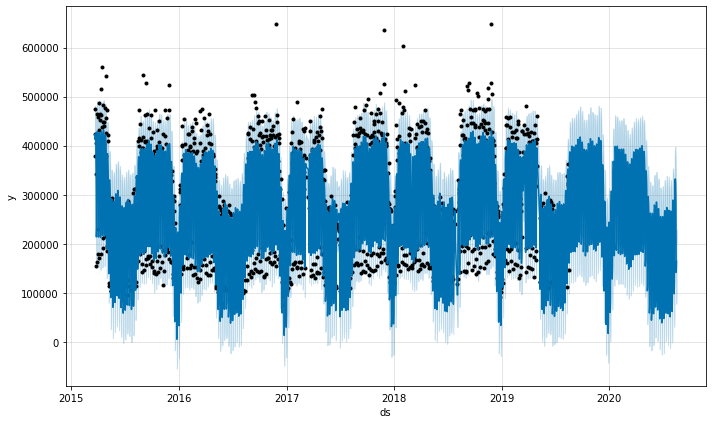

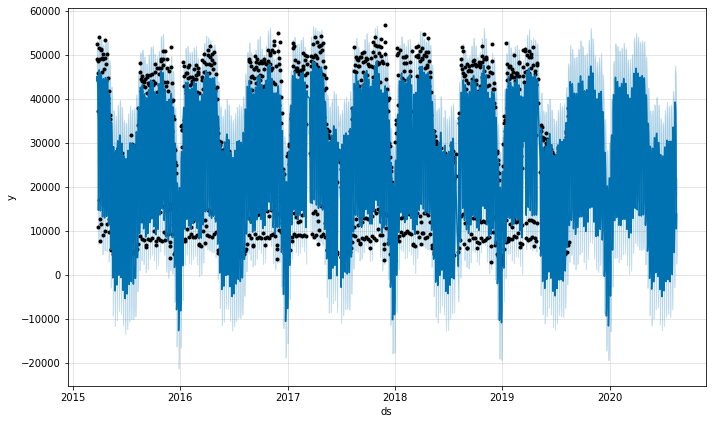

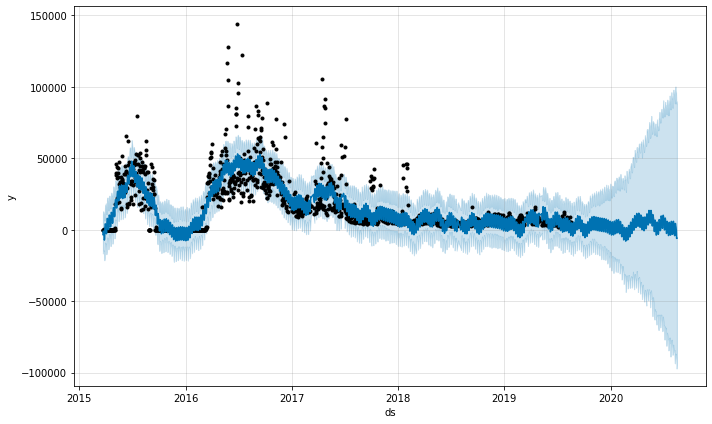

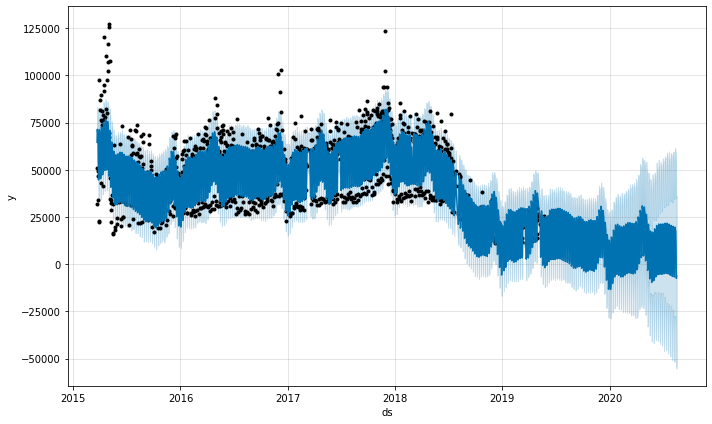

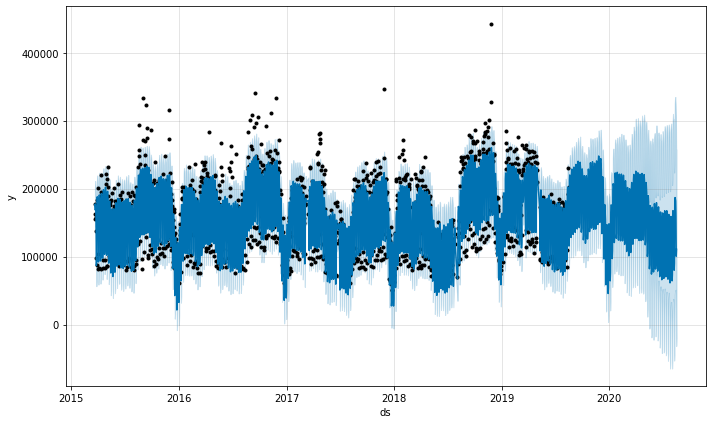

In [515]:
prediction1 = send_prediction(five_att_0_removed)

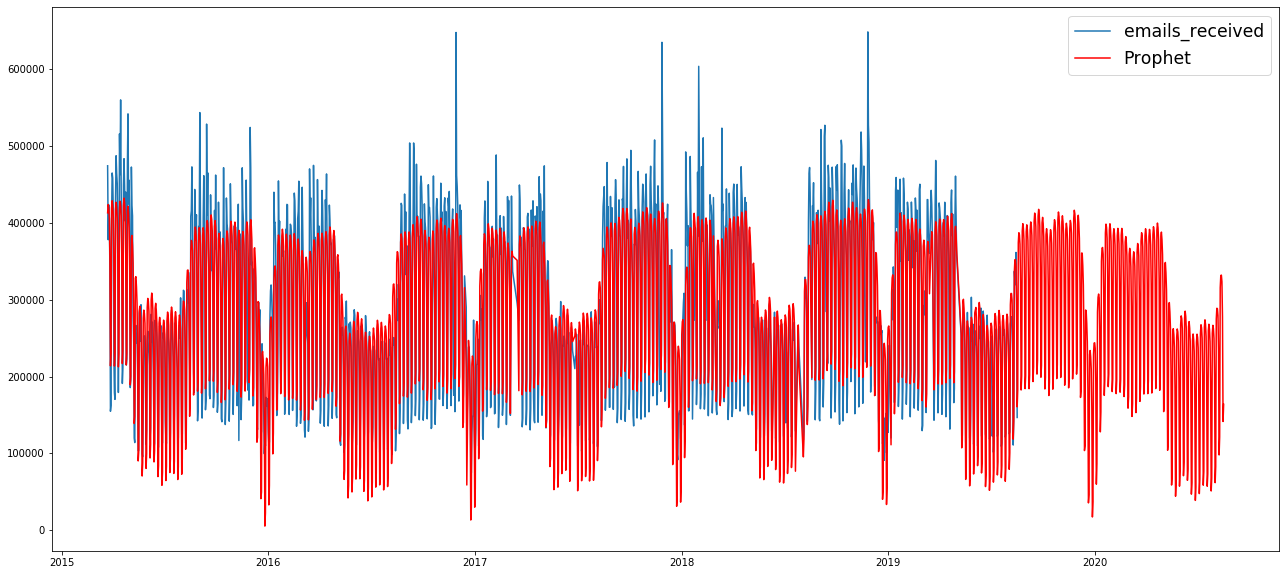

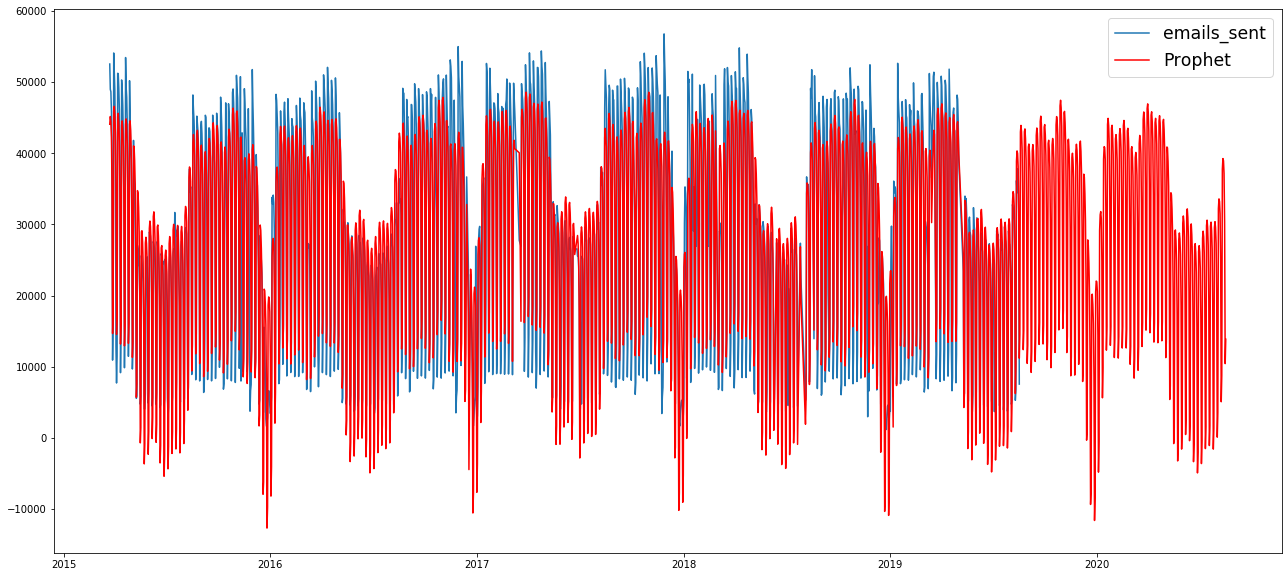

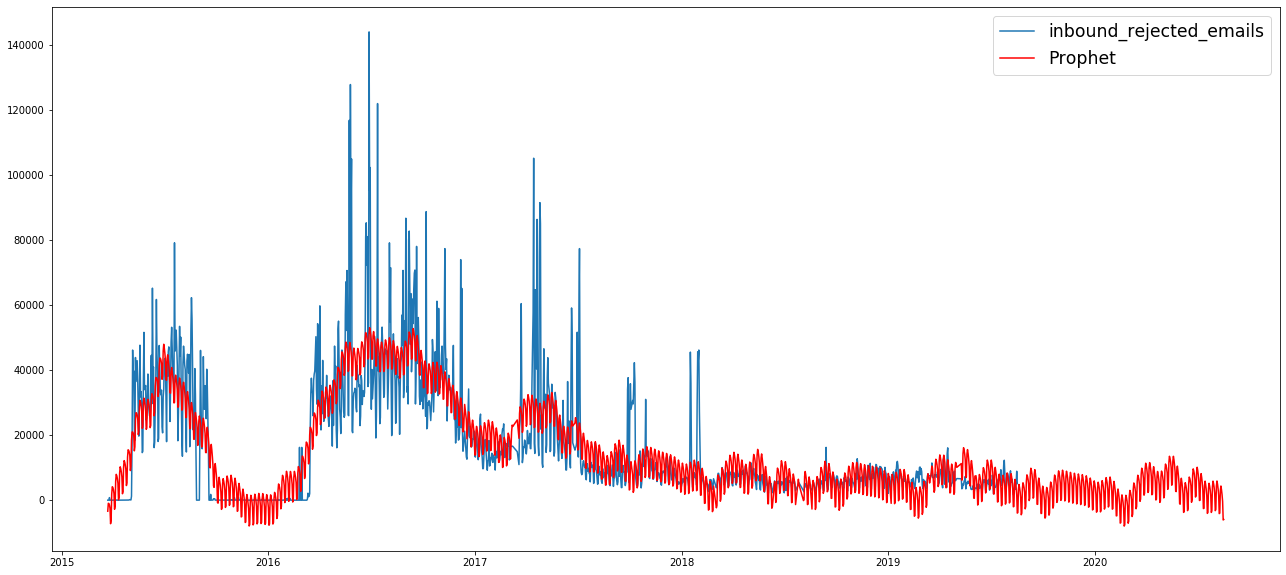

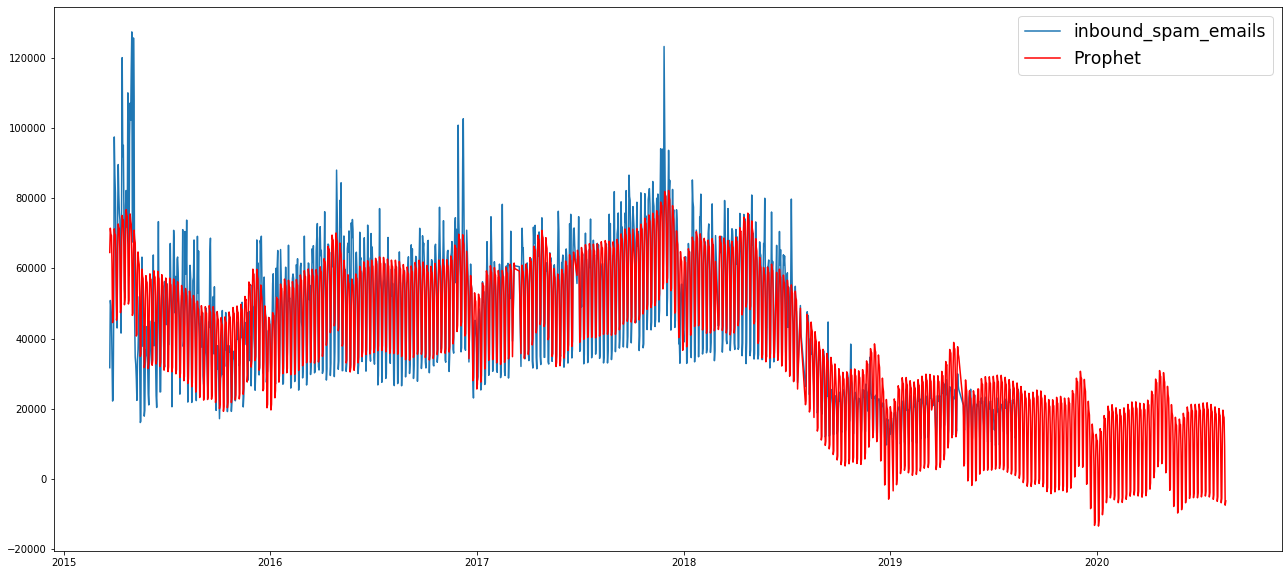

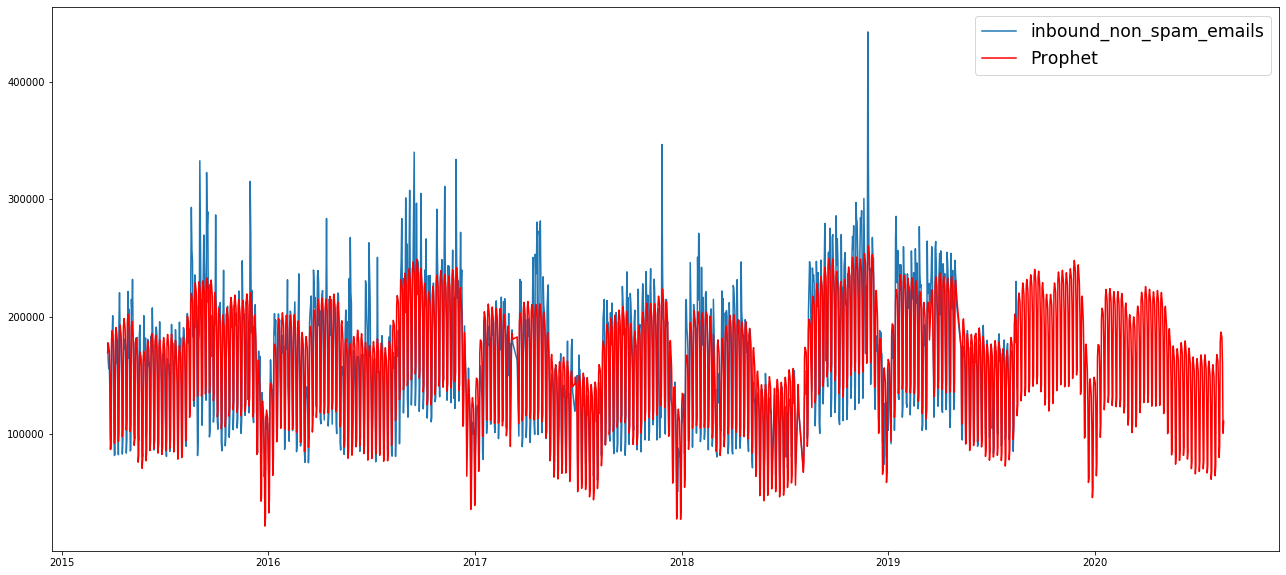

In [516]:
plot(five_att_0_removed,prediction1)